# Climate Change Belief Analysis

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re
nltk.download('stopwords')
porterStemmer = nltk.PorterStemmer()
wordNetLemma = nltk.WordNetLemmatizer()
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Train and Test Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [4]:
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [5]:
believe = train[train['sentiment'] == 1]
no_belief = train[train['sentiment'] == -1]
neutral = train[train['sentiment'] == 0]
news = train[train['sentiment'] == 2]

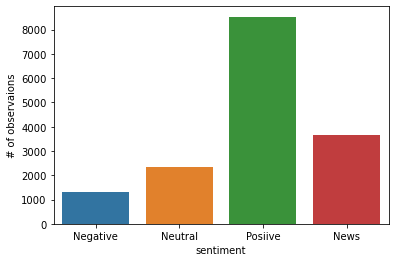

In [6]:
sns.countplot(x = 'sentiment', data = train).set_xticklabels(['Negative','Neutral','Posiive','News'])
plt.ylabel('# of observaions')
plt.show()

In [7]:
print(f"Percentage of Positive tweets: {int(np.round(len(believe)/len(train)*100,0))}%")
print(f"Percentage of Negative tweets: {int(np.round(len(no_belief)/len(train)*100,0))}%")
print(f"Percentage of Neutral tweets: {int(np.round(len(neutral)/len(train)*100,0))}%")
print(f"Percentage of News tweets: {int(np.round(len(news)/len(train)*100,0))}%")

Percentage of Positive tweets: 54%
Percentage of Negative tweets: 8%
Percentage of Neutral tweets: 15%
Percentage of News tweets: 23%


In [8]:
from sklearn.utils import resample

In [9]:
class_size = int(len(believe)/2)

In [10]:
# Upsample mijority
no_belief_downsampled = resample(no_belief,
                          replace=True, # sample without replacement (no need to duplicate observations)
                          n_samples=class_size, # match number in minority class
                          random_state=27) # reproducible results

news_upsampled = resample(news,
                          replace=True, 
                          n_samples=class_size,
                          random_state=27)

neutral_upsampled = resample(neutral,
                          replace=True, 
                          n_samples=class_size,
                          random_state=27)

#halving Positive values still we have huge amount of data now we downsample positive observation

believe_downsampled = resample(believe,
                          replace=True, 
                          n_samples=class_size,
                          random_state=27)


# Combine downsampled majority class with minority class
sampled_data = pd.concat([no_belief_downsampled, news_upsampled, neutral_upsampled, believe_downsampled])

In [11]:
sampled_data.sentiment.value_counts()

-1    4265
 2    4265
 1    4265
 0    4265
Name: sentiment, dtype: int64

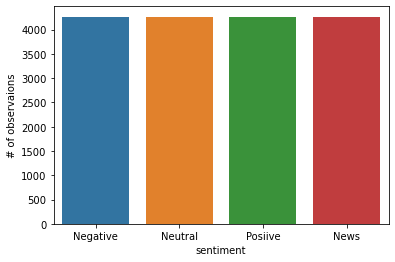

In [12]:
sns.countplot(x = 'sentiment', data = sampled_data).set_xticklabels(['Negative','Neutral','Posiive','News'])
plt.ylabel('# of observaions')
plt.show()

## Data Cleaning and Text Preprocessing

In [13]:
def clean_message(message):
    message = re.sub(r'@[A-Za-z0-9]+','',message) ##Remove @aderate
    message = re.sub(r'#','',message) ##remove #hashtags
    message = re.sub(r'RT[\s]+', '', message) ## remove RT Retweets
    message = re.sub(r'https?:\/\/\S+', '', message) ##remove hyperlink
    message =  ''.join([char for char in message if char not in string.punctuation]) ## remove puntuations i.e. ('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    message = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', '', message) # remove URLs
    message = re.sub(r'@[^\s]+', '', message) # remove usernames

    return message

In [14]:
#Clean Data and add new column called cleaned_message
sampled_data['cleaned_message'] = sampled_data['message'].apply(clean_message)

In [15]:
def remove_emojis(message):
    regrex_pattern = re.compile(pattern = "["
      u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
         "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',message)

In [16]:
sampled_data['cleaned_message'] = sampled_data['cleaned_message'].apply(remove_emojis)

In [17]:
#Get subjectivity
def get_subjectivity(message):
    return TextBlob(message).sentiment.subjectivity

#Get Polarity
def get_polarity(message):
    return TextBlob(message).sentiment.polarity

sampled_data['subjectivity'] = sampled_data['cleaned_message'].apply(get_subjectivity)
sampled_data['polarity'] = sampled_data['cleaned_message'].apply(get_polarity)

In [19]:
believe_sampled = sampled_data[sampled_data['sentiment'] == 1]
no_belief_sampled = sampled_data[sampled_data['sentiment'] == -1]
neutral_sampled = sampled_data[sampled_data['sentiment'] == 0]
news_sampled = sampled_data[sampled_data['sentiment'] == 2]

In [20]:
sampled_data

,sentiment,message,tweetid,cleaned_message,subjectivity,polarity
12819,-1,@ConnorDukeSmith climate change is fake #iamright,69529,climate change is fake iamright,1.0,-0.5
6687,-1,RT @PolitixGal: When govt controls scientific ...,316086,When govt controls scientific research via gr...,0.5,0.0


### Get **Subjectivity** and ** Polarity**

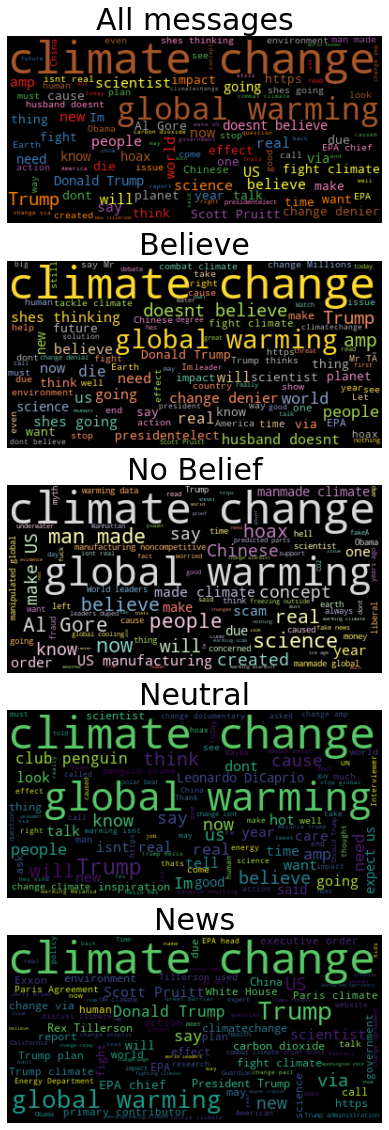

In [21]:
## plot word cloud (simply most used words in different sentiments)

allMessages = ' '.join([message for message in sampled_data['cleaned_message']])
message_belief = ' '.join(message for message in believe_sampled['cleaned_message'])
message_no_belief = ' '.join(message for message in no_belief_sampled['cleaned_message'])
message_neutral = ' '.join(message for message in neutral_sampled['cleaned_message'])
message_news = ' '.join(message for message in news_sampled['cleaned_message'])

wordCloud_all = WordCloud(max_font_size=50, max_words=100,background_color='black', colormap='Set1',stopwords = STOPWORDS, random_state= 42).generate(allMessages)

wordCloud_belief = WordCloud(max_font_size=50, max_words=100,background_color='black', colormap='Set2' ,stopwords = STOPWORDS,random_state= 42).generate(message_belief)

wordCloud_no_belief = WordCloud(max_font_size=50, max_words=100,background_color='black', colormap='Set3',stopwords = STOPWORDS, random_state= 42).generate(message_no_belief)

wordCloud_neutral = WordCloud(max_font_size=50, max_words=100,background_color='black',stopwords = STOPWORDS, random_state= 42).generate(message_neutral)

wordCloud_news = WordCloud(max_font_size=50, max_words=100,background_color='black',stopwords = STOPWORDS, random_state= 42).generate(message_news)

fig, ax = plt.subplots(5, 1, figsize  = (10,20))

ax[0].imshow(wordCloud_all, interpolation="bilinear")
ax[0].set_title('All messages', fontsize = 30)
ax[0].axis('off')

ax[1].imshow(wordCloud_belief, interpolation="bilinear")
ax[1].set_title('Believe', fontsize = 30)
ax[1].axis('off')

ax[2].imshow(wordCloud_no_belief, interpolation="bilinear")
ax[2].set_title('No Belief', fontsize = 30)
ax[2].axis('off')

ax[3].imshow(wordCloud_neutral, interpolation="bilinear")
ax[3].set_title('Neutral', fontsize = 30)
ax[3].axis('off')

plt.imshow(wordCloud_news, interpolation="bilinear")
plt.title('News', fontsize = 30)
plt.axis('off')
plt.show()

In [26]:
#plot polarity and Subjectivity

plt.figure(figsize=(8,6))
#Check for last 100 message
for i in range(15719, train.shape[0]):
    plt.scatter(train['polarity'][i], train['subjectivity'][i], color='Blue')

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

KeyError: 15719

### Tokenization

In [28]:
def tokenization(message):
    message = word_tokenize(message)
    return message

sampled_data['message_tokenized'] = sampled_data['cleaned_message'].apply(lambda x: tokenization(x.lower()))

### Remove Stop Words

In [30]:
stopword = stopwords.words('english')
stopword.extend(['https', 'shes', 'isnt','Im',])

In [31]:
def remove_stopwords(message):
    filtered_message = [word for word in message if word not in stopword]
    return filtered_message
    
sampled_data['message_nonstop'] = sampled_data['message_tokenized'].apply(lambda x: remove_stopwords(x))

### Stemming and Lemmatization

In [15]:
#stemming removes or stems the last few characters of a word, often leading to incorrect meanings and spelling
def stemming(message):
    message = [porterStemmer.stem(word) for word in message]
    return message

sampled_data['message_stemmed'] = sampled_data['message_nonstop'].apply(lambda x: stemming(x))

In [42]:
#word lemma converts word to meaningful base (e.g truncation -> trunc)

def lemmatizer(message):
    return ' '.join([wordNetLemma.lemmatize(word) for word in message])

sampled_data['message'] = sampled_data['message_nonstop'].apply(lambda x: lemmatizer(x))

In [51]:
countVectorizer = CountVectorizer(analyzer=remove_stopwords) 
countVector = countVectorizer.fit_transform(sampled_data['message'])
print('{} Number of tweets has {} words'.format(countVector.shape[0], countVector.shape[1]))

17060 Number of tweets has 219 words


## Splitting out the X variable from the target

In [53]:
X = sampled_data['message']
y = sampled_data['sentiment']

## Turning text into something  model can read

In [54]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words="english")
X_vectorized = vectorizer.fit_transform(X)

## Splitting the training data into a training and validation set

In [57]:
X_train,X_val,y_train,y_val = train_test_split(X_vectorized,y,test_size=.3,shuffle=True, stratify=y, random_state=11)

## Training the model and evaluating using the validation set